<a href="https://colab.research.google.com/github/yncute/optcg_classifier/blob/main/card_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NEEDS WORK:
*   (DONE) implement dynamically augmented data for training and testing
*   create testing dataset





##Imports

In [ ]:
import json
import pickle
import pandas as pd
import cv2
import os
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance
from urllib.request import urlopen
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import numpy as np
import random
import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import matplotlib.pyplot as plt
import shutil
from time import localtime, strftime, time
from natsort import natsorted
from IPython.display import display

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Function definitions

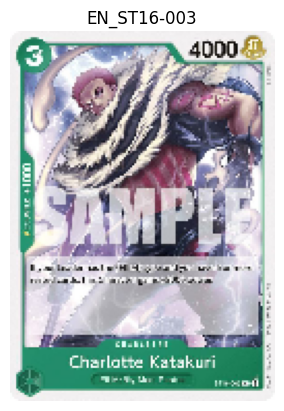

In [ ]:
dataset_path = "/content/drive/MyDrive/dataset/optcg_cards"

def get_label(file_name):
  # Extract class name from filename (e.g. 'EN_ST16-003.jpg' -> 'EN_ST16-003')
  label = file_name.split('.')[0]
  return label

# Load and resize image to 313 x 224 (maintaining apsect ratio of the original 600 x 838)
def load_image(file_path, image_size=(179, 128)):
  image = tf.io.read_file(file_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, image_size)
  image = image / 255.0 # Normalize to [0,1]
  return image

def display_image(image, title=""):
  plt.imshow(image)
  plt.title(title)
  plt.axis('off')
  plt.show()
# Example
image_path = dataset_path + "/EN_ST16-003.jpg"

kata = load_image(image_path)

display_image(kata, "EN_ST16-003")

In [72]:
def get_file_paths(dataset_path, size=None):
  file_names = os.listdir(dataset_path)

  if size is None:
    file_paths = [os.path.join(dataset_path, fname) for fname in file_names]
  else:
    file_paths = [os.path.join(dataset_path, fname) for fname in file_names[:size]]
  return file_paths

def extract_labels(file_names):
  labels = [get_label(fname) for fname in file_names]
  return labels

def convert_labels_to_int(labels):
  unique_labels = sorted(set(labels))
  label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
  int_labels = [label_to_int[label] for label in labels]
  return int_labels, unique_labels



##Augmentation

In [73]:
def augment_image(image):
    # Random rotation
    image = tf.image.random_hue(image, max_delta=0.1)  # 90-degree rotation

    # Random contrast
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)

    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    return image

# used to create raw image copies for training and augmentation
def duplicate_images(file_path, label, num_duplicates=5):
  return tf.data.Dataset.from_tensors((file_path, label)).repeat(num_duplicates)

def preprocess_and_augment_image(image_path, label, image_size=(179,128)):
  # load image
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)

  # resize
  image = tf.image.resize(image, image_size)

  #augment
  image = augment_image(image)

  #normalize
  image = image / 255.0

  return image, label

def create_dataset(dataset_path, sample_size=None, image_size=(179,128), batch_size=32):
  # get file paths/labels
  file_paths = get_file_paths(dataset_path, sample_size)
  labels = extract_labels([os.path.basename(f) for f in file_paths])

  #convert labels to integers
  int_labels, unique_labels = convert_labels_to_int(labels)

  # create a tf dataset
  dataset = tf.data.Dataset.from_tensor_slices((file_paths, int_labels))

  # duplicate each image and label
  dataset = dataset.flat_map(lambda x, y: duplicate_images(x, y))

  # apply preprocessing and augmentation to each image
  dataset = dataset.map(lambda x, y: preprocess_and_augment_image(x, y, image_size),
                        num_parallel_calls=tf.data.AUTOTUNE)

  # shuffle and batch
  dataset = dataset.shuffle(len(file_paths)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

  return dataset

##Model Definition

In [ ]:
def create_model(input_shape=(128, 179, 3), num_classes=None):
  model = models.Sequential([
      # First convolutional layer
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
      layers.MaxPooling2D((2, 2)),

      # Second convolutional layer
      layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
      layers.MaxPooling2D((2, 2)),

      # Third convolutional layer
      layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
      layers.MaxPooling2D((2, 2)),

      # Flatten the output to feed into fully connected layers
      layers.Flatten(),

      # Fully connected (dense) layer
      layers.Dense(128, activation='relu'),

      # Output layer
      layers.Dense(num_classes, activation='softmax')
  ])

  return model

def compile_model(model, learning_rate=0.001):
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

# Train the model
def train_model(model, dataset, epochs=10, batch_size=32):
    model.fit(dataset, epochs=epochs, batch_size=batch_size)

##Model Training

In [71]:
dataset_path = "/content/drive/MyDrive/dataset/optcg_cards"
sample_size=128

dataset = create_dataset(dataset_path, sample_size, image_size=(179,128), batch_size=32)

model = create_model(input_shape=(179,128,3), num_classes=sample_size)

compile_model(model)

train_model(model, dataset, epochs=10)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 132ms/step - accuracy: 0.0251 - loss: 4.8683
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.0897 - loss: 4.6166
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.2753 - loss: 3.8138
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.4879 - loss: 2.1377
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.6319 - loss: 1.2845
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.6512 - loss: 1.1505
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6770 - loss: 1.1349
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7178 - loss: 0.8123
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.7450 - loss: 0.6807
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.7499 - loss: 0.6116


##Model Evaluation and Prediction

In [74]:
test_dataset = create_dataset(dataset_path, sample_size)

loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss}, Accuracy: {accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step - accuracy: 0.7664 - loss: 0.5874
Loss: 0.5138767957687378, Accuracy: 0.7875000238418579


In [ ]:
test_image = load_image("/content/drive/MyDrive/dataset/optcg_cards/EN_OP06-089_pPR.jpg")
test_image = tf.expand_dims(test_image, axis=0)  # Add batch dimension

predictions = model.predict(test_image)
predicted_class = unique_labels[tf.argmax(predictions[0]).numpy()]
print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Predicted Class: EN_OP06-089_pPR
